In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Activation
from keras.datasets import cifar10

Using TensorFlow backend.


In [4]:
# load CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

# reshape CIFAR
# x_train = x_train.reshape(50000, 32*32*3)
# x_test = x_test.reshape(10000, 32*32*3)

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

50000 train samples, 10000 test samples
training data shape:  (50000, 32, 32, 3) (50000, 10)
test data shape:  (10000, 32, 32, 3) (10000, 10)


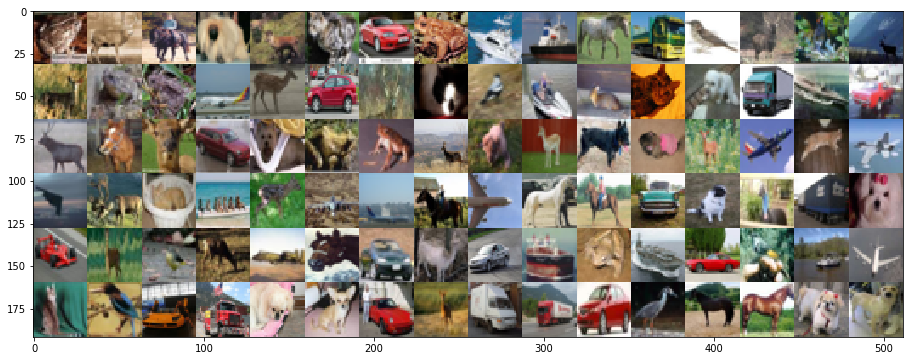

In [3]:
samples = np.concatenate([np.concatenate([x_train[i].reshape((32,32,3)) for i in [int(random.random() * len(x_train)) for i in range(16)]], axis=1) for i in range(6)], axis=0)
plt.figure(figsize=(16,6))
plt.imshow(samples, cmap='gray')

In [2]:
from keras.models import load_model
model = load_model('my_model.h5')
y_actual_list = cifar10.load_data()[1][1]
target_string =  np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])

In [5]:
import os
import time,datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

def train(model, batch, epoch, data_augmentation=True):
    start = time.time()
    log_dir = datetime.time().strftime('model_%Y%m%d_%H%M')
    os.mkdir(log_dir)
    
    es = EarlyStopping(monitor='val_acc', patience=20)
    mc = ModelCheckpoint(log_dir + '\\CIFAR10-EP{epoch:02d}-ACC{val_acc:.4f}.h5', 
                         monitor='val_acc', save_best_only=True)
    tb = TensorBoard(log_dir=log_dir, histogram_freq=0)
    
    if data_augmentation:
        aug = ImageDataGenerator(width_shift_range = 0.125, height_shift_range = 0.125, horizontal_flip = True)
        aug.fit(x_train)
        gen = aug.flow(x_train, y_train, batch_size=batch)
        h = model.fit_generator(generator=gen, 
                                 steps_per_epoch=50000/batch, 
                                 epochs=epoch, 
                                 validation_data=(x_test, y_test),
                                 callbacks=[es, mc, tb])
    else:
        start = time()
        h = model.fit(x=x_train, 
                      y=y_train, 
                      batch_size=batch, 
                      epochs=epoch, 
                      validation_data=(x_test, y_test),
                      callbacks=[es, mc, tb])
    
    print('\n@ Total Time Spent: %.2f seconds' % (time.time() - start))
    acc, val_acc = h.history['acc'], h.history['val_acc']
    m_acc, m_val_acc = np.argmax(acc), np.argmax(val_acc)
    print("@ Best Training Accuracy: %.2f %% achieved at EP #%d." % (acc[m_acc] * 100, m_acc + 1))
    print("@ Best Testing Accuracy: %.2f %% achieved at EP #%d." % (val_acc[m_val_acc] * 100, m_val_acc + 1))
    return h

In [ ]:
train(model, 128, 100, True)

model.save('my_model.h5') 

In [6]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Training loss: 0.21428894408464433
Training accuracy: 0.92522
Test loss: 0.5153231621384621
Test accuracy: 0.8515


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 48)        13872     
__________

7756


([<matplotlib.axis.XTick at 0x12ec5e780>,
 <a list of 10 Text xticklabel objects>)

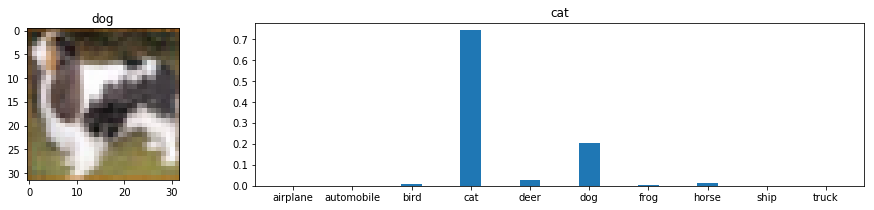

In [18]:
rdm = int(random.random()*10000)
print(rdm)

x_sample = x_test[rdm].reshape(1,32,32,3)
y_prob = model.predict(x_sample)[0]
#print(y_prob.shape)
y_pred = y_prob.argmax()

#print("predicted = %d, actual = %d" % (y_pred, y_actual_list[rdm]))
y_acual = y_test[rdm].argmax()

# plot it
f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 4]})
f.set_figwidth(15)
f.set_figheight(3)

# plt.subplot(1,2,1)
a0.imshow(x_test[rdm])
a0.set_title(target_string[y_acual])

# plt.subplot(1,2,2)
width = 0.35       # the width of the bars: can also be len(x) sequence
a1.bar(range(10), y_prob, width)
a1.set_title(target_string[y_pred])
plt.xticks(range(10),target_string)